In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from fastai.vision.all import *
from fastai import *

In [3]:
train_df = pd.read_csv("../input/plant-pathology-2020-fgvc7/train.csv")
test_df = pd.read_csv("../input/plant-pathology-2020-fgvc7/test.csv")

In [4]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [5]:
train_df['label'] = train_df[list(train_df.iloc[0,:].index)[1:]].idxmax(axis=1)

In [6]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [7]:
train_df = train_df.drop(['healthy', 'multiple_diseases', 'rust', 'scab'], axis=1)

In [7]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [8]:
path = Path("../input/plant-pathology-2020-fgvc7/images")
path

Path('../input/plant-pathology-2020-fgvc7/images')

In [9]:
VOCAB_LIST = ['healthy', 'multiple_diseases', 'rust', 'scab']

In [10]:
def get_x(f):
    return f"{path}/{f['image_id']}.jpg"

def get_y(f):
    return f['label']

In [11]:
print(get_x(train_df.iloc[0,:])); get_y(train_df.iloc[0,:])

../input/plant-pathology-2020-fgvc7/images/Train_0.jpg


'scab'

In [12]:
Image.open(get_x(train_df.iloc[0,:])).size

(2048, 1365)

In [16]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_x = get_x, get_y = get_y,
                  item_tfms=Resize(224))
dsets = dblock.datasets(train_df)

In [17]:
dsets.train[0]

(PILImage mode=RGB size=2048x1365, TensorCategory(1))

In [18]:
dsets.vocab

['healthy', 'multiple_diseases', 'rust', 'scab']

In [19]:
len(dsets.train), len(dsets.valid)

(1457, 364)

In [20]:
dls = dblock.dataloaders(train_df,bs=32)

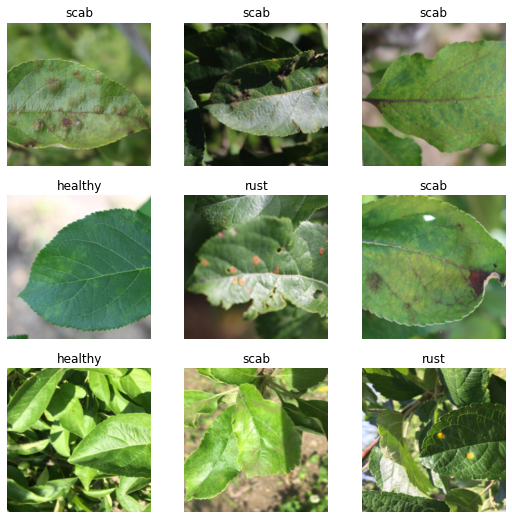

In [21]:
dls.show_batch()

In [ ]:
dls.train

In [12]:
np.eye(4)[]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
def total_error_metric(preds, targets, labels = range(len(VOCAB_LIST))):
    #one-hot encoded targets
    targets = np.eye(4)[targets]
    return np.mean([roc_auc_score(targets[:,i],preds[:,i]) for i in labels])

def healthy_roc_Auc(*args):
    return total_error_metric(*args, labels = [0])

def multiple_diseases_roc_Auc(*args):
    return total_error_metric(*args, labels = [1])

def rust_roc_Auc(*args):
    return total_error_metric(*args, labels = [2])

def scab_roc_Auc(*args):
    return total_error_metric(*args, labels = [3])

In [25]:
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(),
                   metrics = [
                       AccumMetric(healthy_roc_Auc, flatten = False),
                       AccumMetric(multiple_diseases_roc_Auc, flatten = False),
                       AccumMetric(rust_roc_Auc, flatten = False),
                       AccumMetric(scab_roc_Auc, flatten= False),
                       AccumMetric(total_error_metric, flatten = False)
                   ]).to_fp16()


SuggestedLRs(valley=0.0006918309954926372)

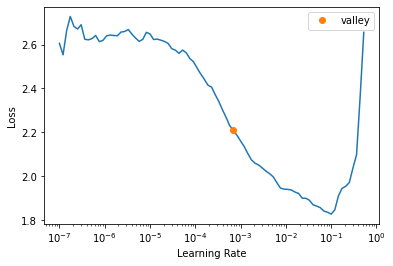

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,healthy_roc_Auc,multiple_diseases_roc_Auc,rust_roc_Auc,scab_roc_Auc,total_error_metric,time
0,1.467281,1.044796,0.903330,0.624378,0.970757,0.952281,0.862686,01:20
1,1.146596,0.964719,0.952777,0.663968,0.968893,0.961667,0.886826,01:19
2,0.924991,0.759920,0.951300,0.702091,0.977305,0.972386,0.900771,01:20
3,0.787808,0.732519,0.960143,0.710187,0.981428,0.976509,0.907067,01:20


epoch,train_loss,valid_loss,healthy_roc_Auc,multiple_diseases_roc_Auc,rust_roc_Auc,scab_roc_Auc,total_error_metric,time
0,0.745325,0.802952,0.953832,0.732947,0.976117,0.955509,0.904601,01:21
1,0.749662,0.704109,0.968429,0.664669,0.988257,0.959825,0.895295,01:20
2,0.637704,0.550829,0.979132,0.749076,0.992809,0.970070,0.922772,01:21
3,0.534597,0.519195,0.987111,0.824047,0.987069,0.972246,0.942618,01:21
4,0.476883,0.496180,0.982315,0.884865,0.991885,0.965912,0.956245,01:21
5,0.442836,0.504750,0.988415,0.821879,0.991225,0.961684,0.940801,01:20
6,0.420841,0.493036,0.977961,0.851842,0.991753,0.969105,0.947666,01:21
7,0.410119,0.488256,0.980244,0.844575,0.991819,0.965526,0.945541,01:21


Path('models/base_model.pth')

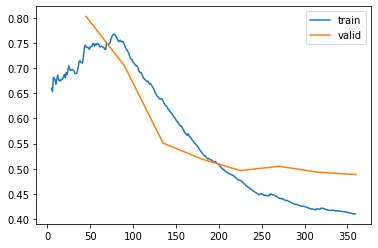

In [27]:
learn.fit_one_cycle(4)
learn.unfreeze()
learn.fit_one_cycle(8,lr_max = slice(1e-5,3e-3))
learn.recorder.plot_loss()
learn.save('base_model')

In [28]:
all_val_preds, all_val_labels, all_test_preds = [], [], []

val_preds, val_labels = learn.get_preds()
all_val_preds.append(val_preds)
all_val_labels.append(val_labels)

test_dl = dls.test_dl(test_df)
test_preds, _ = learn.get_preds(dl=test_dl)
all_test_preds.append(test_preds)

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

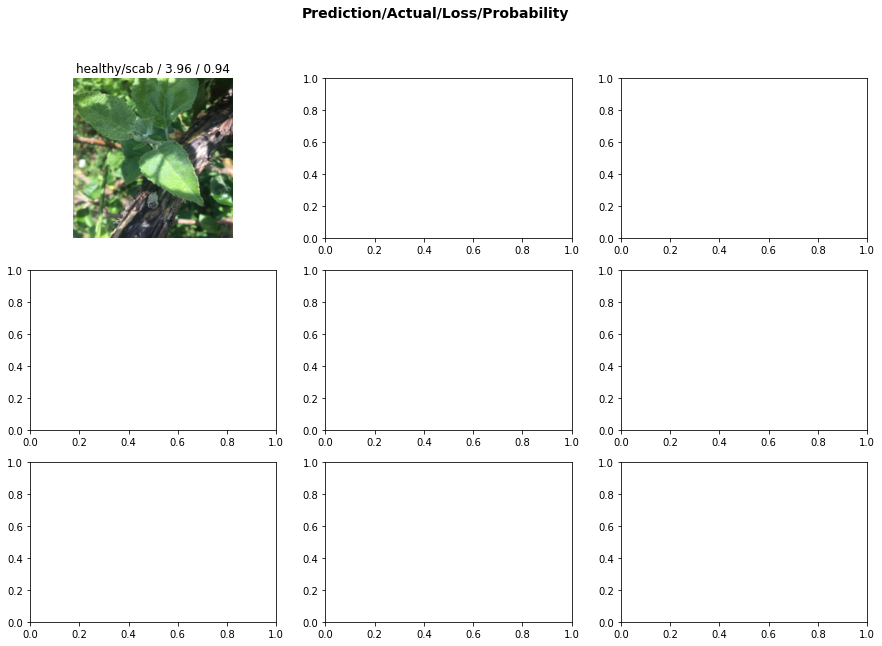

In [33]:
interp.plot_top_losses(9, figsize = (15,10))

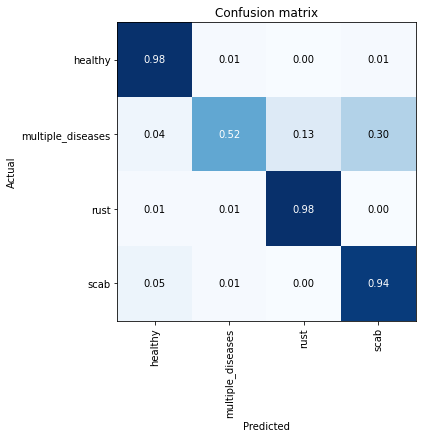

In [32]:
interp.plot_confusion_matrix(normalize=True, figsize = (6,6))

In [34]:
test_df_output = pd.concat([test_df, pd.DataFrame(np.mean(np.stack(all_test_preds), axis=0), columns= VOCAB_LIST)], axis=1)

In [35]:
test_df_output.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.025599,0.062386,0.905051,0.006964
1,Test_1,0.035905,0.035005,0.904992,0.024098
2,Test_2,0.005325,0.014585,0.015546,0.964544
3,Test_3,0.944511,0.018944,0.015163,0.021383
4,Test_4,0.020676,0.021796,0.941829,0.015699


In [36]:
test_df_output.to_csv('baseline_submission.csv',index=False)

In [37]:
!head -n 5 baseline_submission.csv

image_id,healthy,multiple_diseases,rust,scab
Test_0,0.0255992,0.062385865,0.9050506,0.006964343
Test_1,0.03590496,0.035004787,0.9049921,0.024098095
Test_2,0.005325127,0.014585166,0.015545741,0.96454394
Test_3,0.94451064,0.018944,0.015162587,0.021382675
